In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dl
import deeptrack as dt


import numpy as np
import torchvision
import torch

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either cha

In [3]:
train_dataset = dt.Dataset("segmentation_sstem_drosophila", split="train[:80%]")
test_dataset = dt.Dataset("segmentation_sstem_drosophila", split="train[80%:]")

1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.


train_dataset images:  16
test_dataset images:  4
image shape:  (1024, 1024, 1)
masks shape:  (1024, 1024, 1)
masks unique values:  Image(array([  0,  32,  64,  96, 128, 159, 191, 223, 255], dtype=uint8))


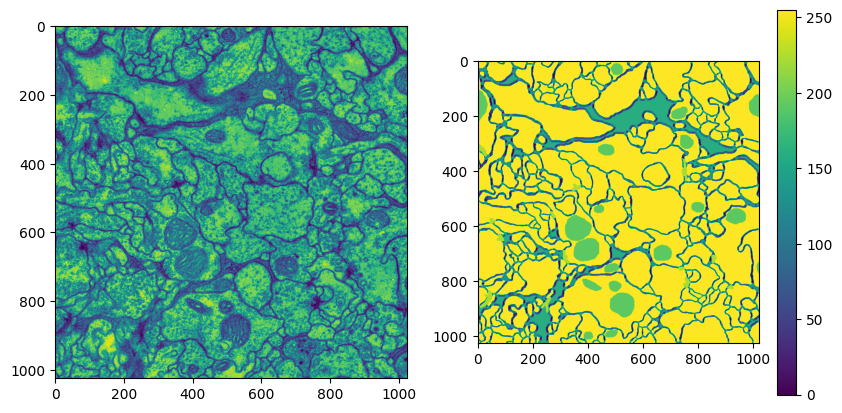

In [4]:
import matplotlib.pyplot as plt
print("train_dataset images: ", train_dataset.size)
print("test_dataset images: ", test_dataset.size)

image, masks = train_dataset.update()()

print("image shape: ", image.shape)
print("masks shape: ", masks.shape)
print("masks unique values: ", np.unique(masks))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(masks)
plt.colorbar()
plt.show()

image shape:  (256, 256, 1)
masks shape:  (256, 256, 1)


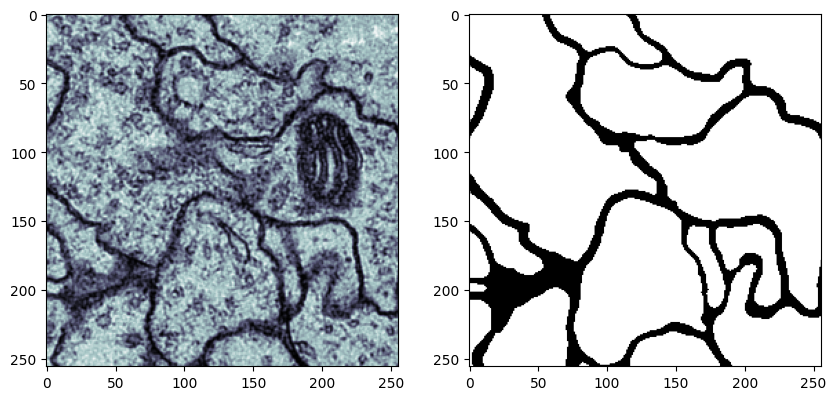

In [5]:
image_processing = dt.Divide(255)
mask_processing = dt.GreaterThan(159)

augmentations = dt.Crop(crop=(256, 256, 1))

train_image_pipeline = train_dataset.image >> image_processing
train_mask_pipeline = train_dataset.label >> mask_processing
train_pipeline = (train_image_pipeline & train_mask_pipeline) >> augmentations 

test_image_pipeline = test_dataset.image >> image_processing
test_mask_pipeline = test_dataset.label >> mask_processing
test_pipeline = test_image_pipeline & test_mask_pipeline

image, masks = train_pipeline.update()()

print("image shape: ", image.shape)
print("masks shape: ", masks.shape)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="bone")
plt.subplot(1, 2, 2)
plt.imshow(masks, cmap="Greys_r")
plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
import copy
import random


class DynamicDeeptrackDataset(Dataset):
    def __init__(self, data_pipeline: dt.Feature, dataset_size: int, replace_probability=1) -> None:

        self.data_pipeline = data_pipeline
        self.replace_probability = replace_probability  # probability of replacing an image

        # peak image size
        _image, _label = data_pipeline.update().resolve()

        _image_as_tensor = to_tensor(np.array(_image)).float().to("cpu")
        _label_as_tensor = to_tensor(np.array(_label)).float().to("cpu")

        self.dataset = torch.empty(
            (dataset_size, *_image_as_tensor.shape), dtype=torch.float32
        )
        self.labels = torch.empty(
            (dataset_size, *_label_as_tensor.shape), dtype=torch.float32
        )

        self._has_set_once = np.zeros(dataset_size, dtype=bool)

    def __getitem__(self, index):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            self._maybe_replace_index(self.data_pipeline, index)

        else:
            self._maybe_replace_index(copy.deepcopy(self.data_pipeline), index)

        return self.dataset[index], self.labels[index]

    def __len__(self):
        return len(self.dataset)

    def _maybe_replace_index(self, pipeline, index):

        if self._has_set_once[index] and random.random() > self.replace_probability:
            return
            
        data, label = self.data_pipeline.update().resolve()
        tensor_data = to_tensor(np.array(data)).float().to("cpu")

        self._has_set_once[index] = True
        self.dataset[index] = tensor_data
        self.labels[index] = to_tensor(np.array(label)).float().to("cpu")

In [7]:
train_torch_dataset = DynamicDeeptrackDataset(train_pipeline, 256, 0.5)
test_torch_dataset = DynamicDeeptrackDataset(test_pipeline, test_dataset.size)

train_torch_dataloader = DataLoader(train_torch_dataset, batch_size=8, shuffle=True)
test_torch_dataloader = DataLoader(test_torch_dataset, batch_size=2, shuffle=False)

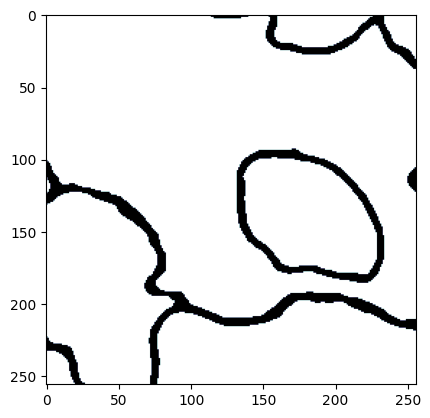

In [8]:
sample_image, sample_label = train_torch_dataset[0] 
sample_label.shape

plt.imshow(sample_label[0], cmap="bone")

In [9]:
segmentor = dl.ImageSegmentor(
    backbone = dl.ConvolutionalEncoderDecoder()
)
segmentor(sample_image.unsqueeze(0))
segmentor

ImageSegmentor(
  (backbone): ConvolutionalEncoderDecoder(
    (encoder_blocks): ModuleList(
      (0): Template(
        (layer): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Template(
        (layer): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Template(
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Template(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [10]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=100, accelerator="cuda", devices=1, log_every_n_steps=1)
trainer.fit(segmentor, train_torch_dataloader, test_torch_dataloader)
trainer.test(segmentor, test_torch_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                        | Params
---------------------------------------------------------
0 | backbone | ConvolutionalEncoderDecoder | 195 K 
1 | head     | ImageSegmentationHead       | 17    
2 | loss     | BCELoss                     | 0     
---------------------------------------------------------
195 K     Trainable params
0         Non-trainable params
195 K     Total params
0.781     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.5423514246940613     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.5423514246940613}]

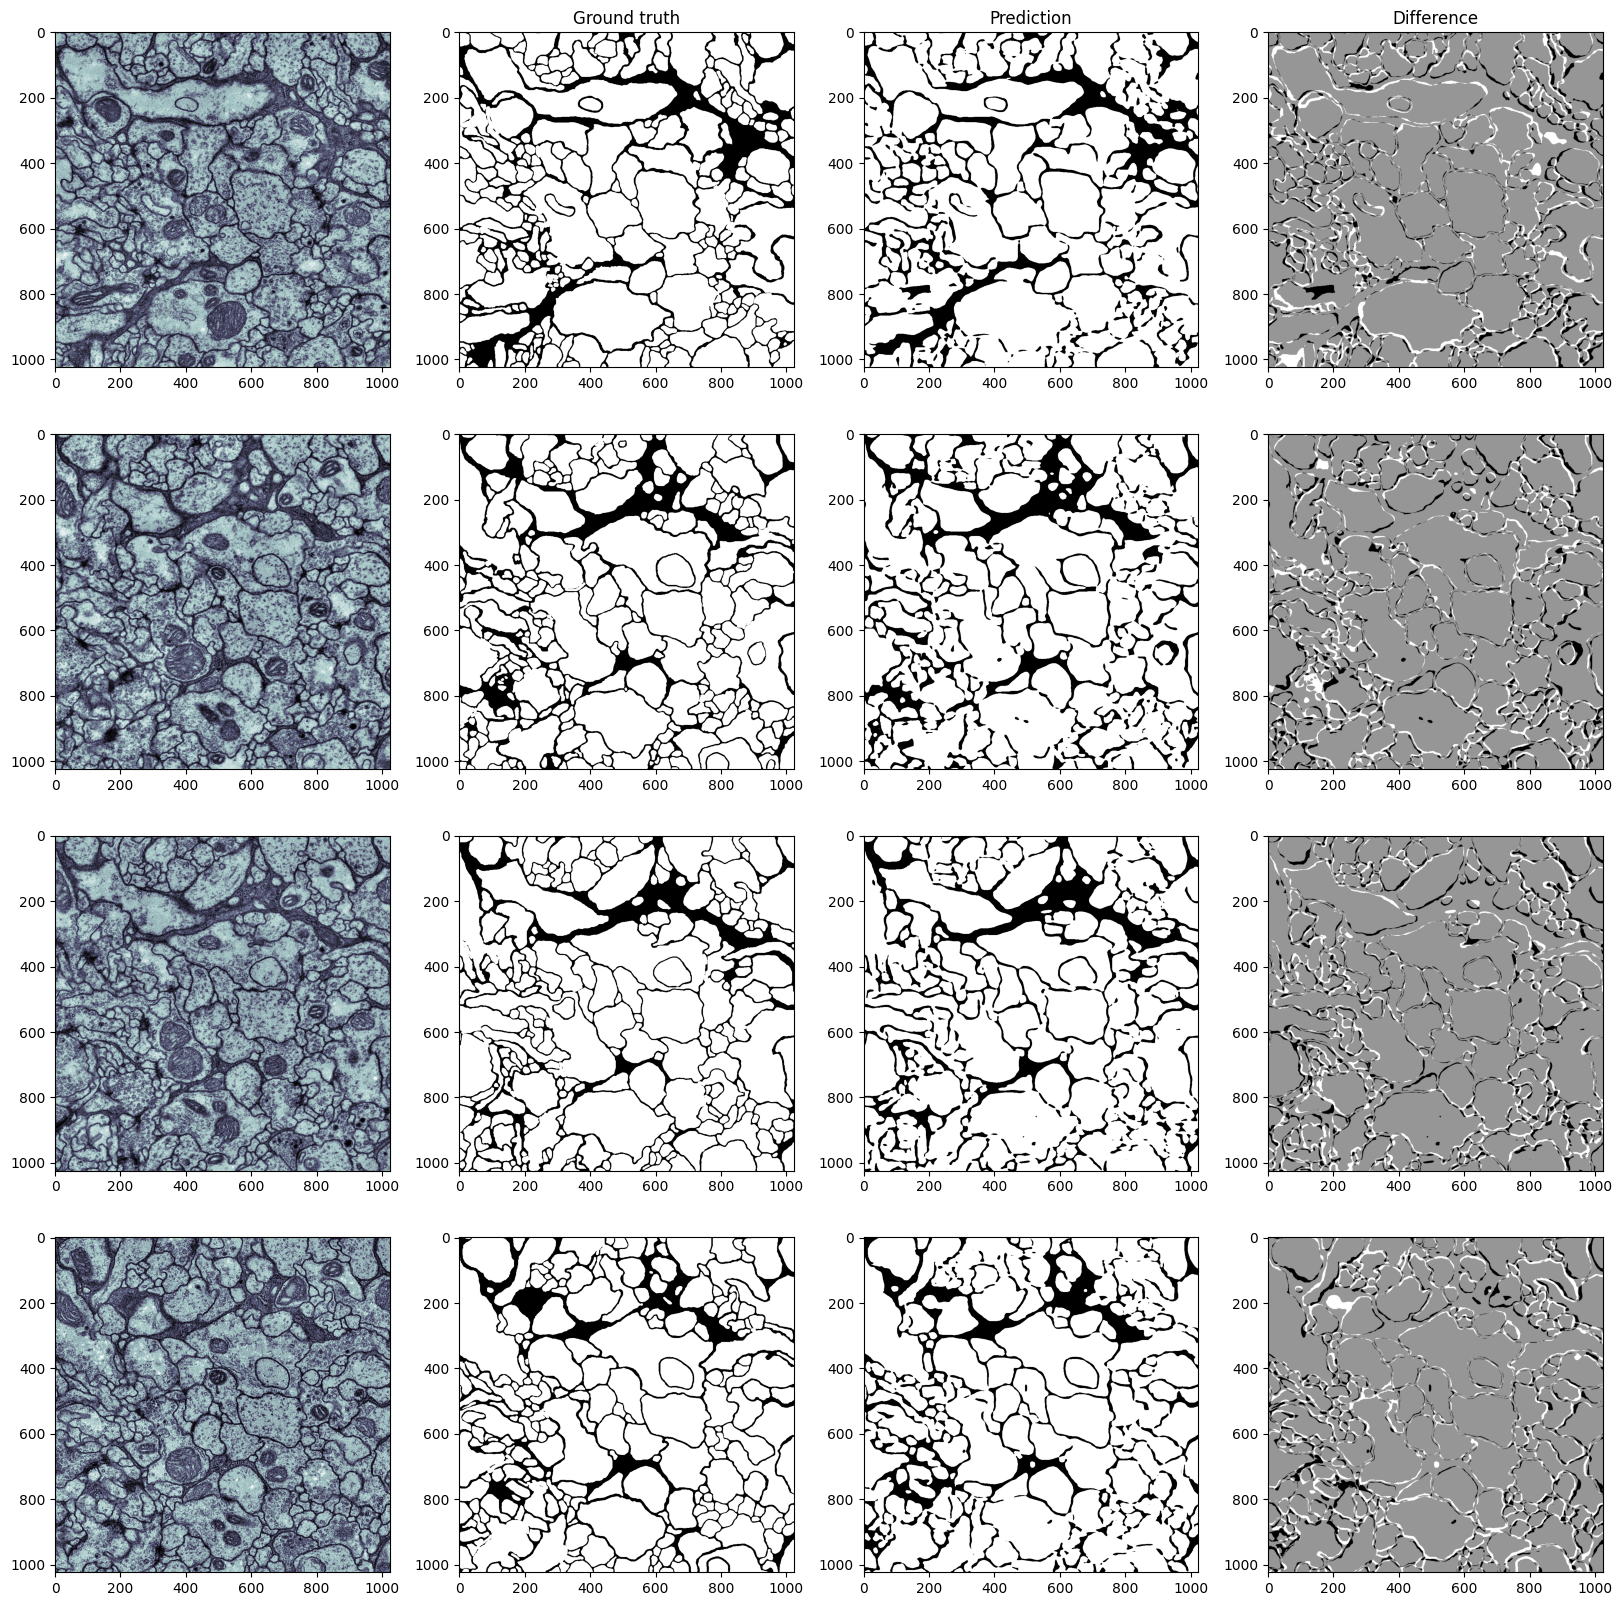

In [ ]:
def plot_all_examples(segmentor, test_torch_dataset, n_examples=4):
    plt.figure(figsize=(20, n_examples * 5))

    for idx, (image, mask) in enumerate(test_torch_dataset):
        semgentation = segmentor.segment(image.unsqueeze(0))

        
        plt.subplot(n_examples, 4, 1 + idx * 4)
        plt.imshow(image[0], cmap="bone")
        plt.subplot(n_examples, 4, 2 + idx * 4)
        plt.imshow(mask[0], cmap="Greys_r")
        if idx == 0:
            plt.title("Ground truth")
        plt.subplot(n_examples, 4, 3 + idx * 4)
        plt.imshow(semgentation[0, 0], cmap="Greys_r")
        if idx == 0:
            plt.title("Prediction")
        plt.subplot(n_examples, 4, 4 + idx * 4)
        plt.imshow(semgentation[0, 0] * 1.0 - mask[0] * 1.0, cmap="Greys_r")
        if idx == 0:
            plt.title("Difference")

    plt.tight_layout()
plot_all_examples(segmentor, test_torch_dataset, n_examples=test_dataset.size)

### 2. Using UNet

To get better results, we will use UNet. UNet is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. The main idea is using forward skip connections from earlier layers to later layers to help the network better understand the context. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. The network is made up of convolutional layers, pooling layers, up-convolutional layers, and concatenation layers.

In [11]:
unet_segmentor = dl.ImageSegmentor(
    backbone = dl.UNet()
)
y = unet_segmentor(sample_image.unsqueeze(0), pad_output=False)
print("Input shape: ", sample_image.shape, "Output shape: ", y.shape)
unet_segmentor

Input shape:  torch.Size([1, 256, 256]) Output shape:  torch.Size([1, 1, 68, 68])


ImageSegmentor(
  (backbone): UNet(
    (input): Template(
      (layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU()
      (layer(0)): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (activation(0)): ReLU()
    )
    (encoder_blocks): ModuleList(
      (0): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (LayerSequence): Template(
          (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (activation): ReLU()
          (layer(0)): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (activation(0)): ReLU()
        )
      )
      (1): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (LayerSequence): Template(
          (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (activation): ReLU()
          (layer(0)): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (acti

Note that the output shape does not match the input shape. This is the configuration of the original UNet. We will use the same configuration for our network.

In [12]:
trainer = pl.Trainer(max_epochs=100, accelerator="cuda", devices=1, log_every_n_steps=1)
trainer.fit(unet_segmentor, train_torch_dataloader, test_torch_dataloader)
trainer.test(unet_segmentor, test_torch_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | backbone | UNet                  | 31.4 M
1 | head     | ImageSegmentationHead | 65    
2 | loss     | BCELoss               | 0     
---------------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.511   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.0}]

In [5]:
unet = dl.UNet.from_config(
    dl.Config().__.layer.padding(1)
)
unet(torch.randn(1, 3, 512, 512)).shape

torch.Size([1, 64, 512, 512])

In [19]:
# Load dataset

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(size=(256, 256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
        
    ]
)

train_dataset = torchvision.datasets.VOCSegmentation(
    root="data", year="2012", image_set="train", download=True, transform=transform
)

test_dataset = torchvision.datasets.VOCSegmentation(
    root="data", year="2012", image_set="val", download=True, transform=transform
)


Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data


In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=4)

In [22]:
# plot some images
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataloader))
plt.imshow(images[0].permute(1, 2, 0))
plt.imshow(labels[0].squeeze(), alpha=0.5)
plt.show()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py", line 143, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py", line 143, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py", line 151, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>


### 1 Simple Encoder-Decoder

First, we will train a simple encoder-decoder model on the Pascal VOC dataset. We expect this model to perform poorly since it does not have any skip connections.

In [5]:
model = dl.ImageSegmentor()

SimpleAutoencoder(
  (encoder): Template(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): LazyLinear(in_features=0, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Template(
    (layer): UninitializedModule()
    (activation): Sigmoid()
    (unflatten): UninitializedModule()
  )
  (loss): MSELoss()
)

Input shape:  torch.Size([32, 1, 28, 28]) 
 Output shape:  torch.Size([32, 1, 28, 28])


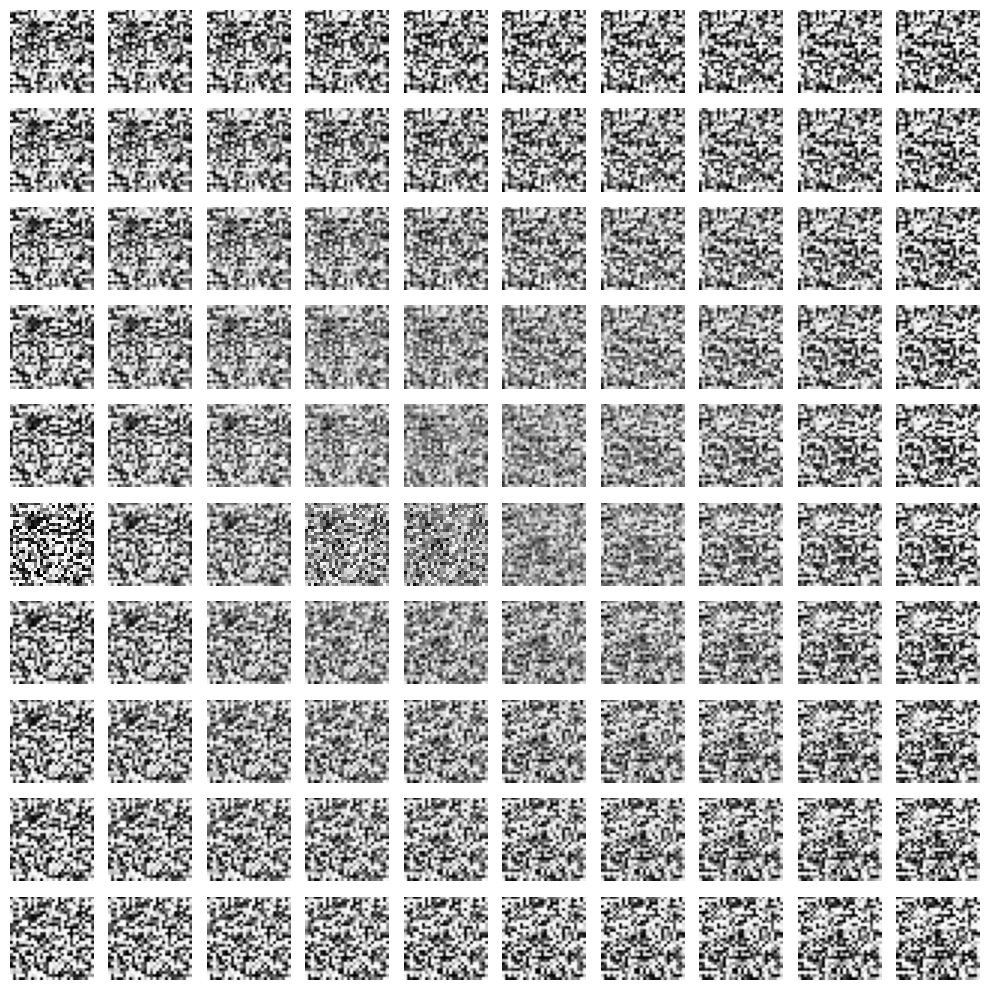

In [6]:
example_batch = next(iter(mnist_dataloader))[0]
example_batch.shape

y = autoencoder(example_batch).shape

print(
    "Input shape: ", example_batch.shape, "\n",
    "Output shape: ", y
)

def generate_examples(model, n=5):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch
    plt.figure(figsize=(10, 10))
    x = np.linspace(-5, 5, n)
    y = np.linspace(-5, 5, n)

    xx, yy = np.meshgrid(x, y)
    xx = torch.tensor(xx).float()
    yy = torch.tensor(yy).float()
    z = torch.stack([xx, yy], dim=-1).view(-1, 2)
    yhat = model.decode(z).detach().cpu().numpy()

    for i in range(n ** 2):
        plt.subplot(n, n, i + 1)
        plt.imshow(yhat[i].transpose((1, 2, 0)), cmap="Greys_r")
        plt.axis("off")

    plt.tight_layout()


generate_examples(autoencoder, 10)
    

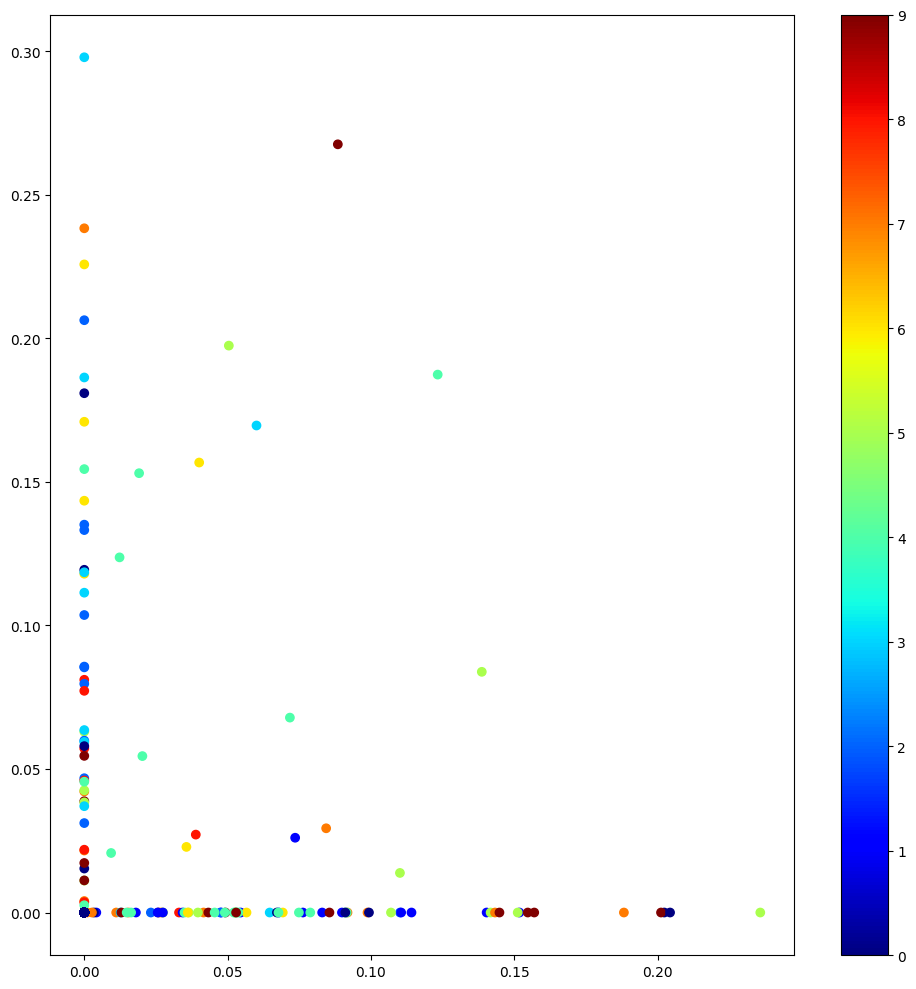

In [7]:


def scatterplot(model, testset):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch

    xy = torch.zeros((len(testset) * 32, 2))
    test_classes = torch.zeros((len(testset) * 32))

    i0 = 0
    for i, (x, y) in enumerate(testset):
        yhat = model.encode(x.view(-1, 1, 28, 28)).detach().cpu()
        xy[i:i + len(yhat)] = yhat
        test_classes[i:i + len(yhat)] = y.cpu().view(-1)
   
    plt.figure(figsize=(10, 10))
    plt.scatter(xy[:, 0], xy[:, 1], c=test_classes, cmap="jet")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

scatterplot(autoencoder, mnist_test_dataloader)

In [8]:
autoencoder = dtm.SimpleAutoencoder(hidden_dim=2)
autoencoder(torch.zeros((1, 1, 28, 28)))

trainer = pl.Trainer(max_epochs=5, accelerator="cuda")
trainer.fit(autoencoder, mnist_dataloader, mnist_test_dataloader)
trainer.test(dataloaders=mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | encoder | Template | 1.6 K 
1 | decoder | Template | 2.4 K 
2 | loss    | MSELoss  | 0     
-------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_65\checkpoints\epoch=4-step=9375.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_65\checkpoints\epoch=4-step=9375.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05950499325990677    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05950499325990677}]

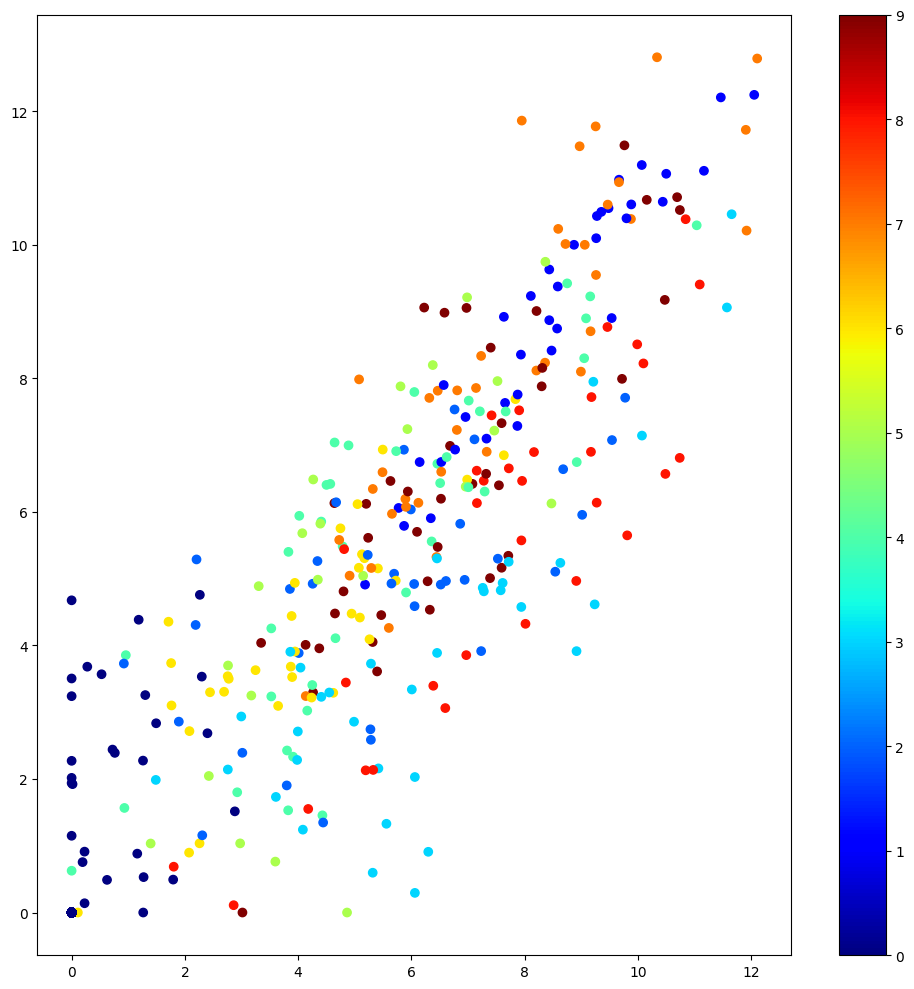

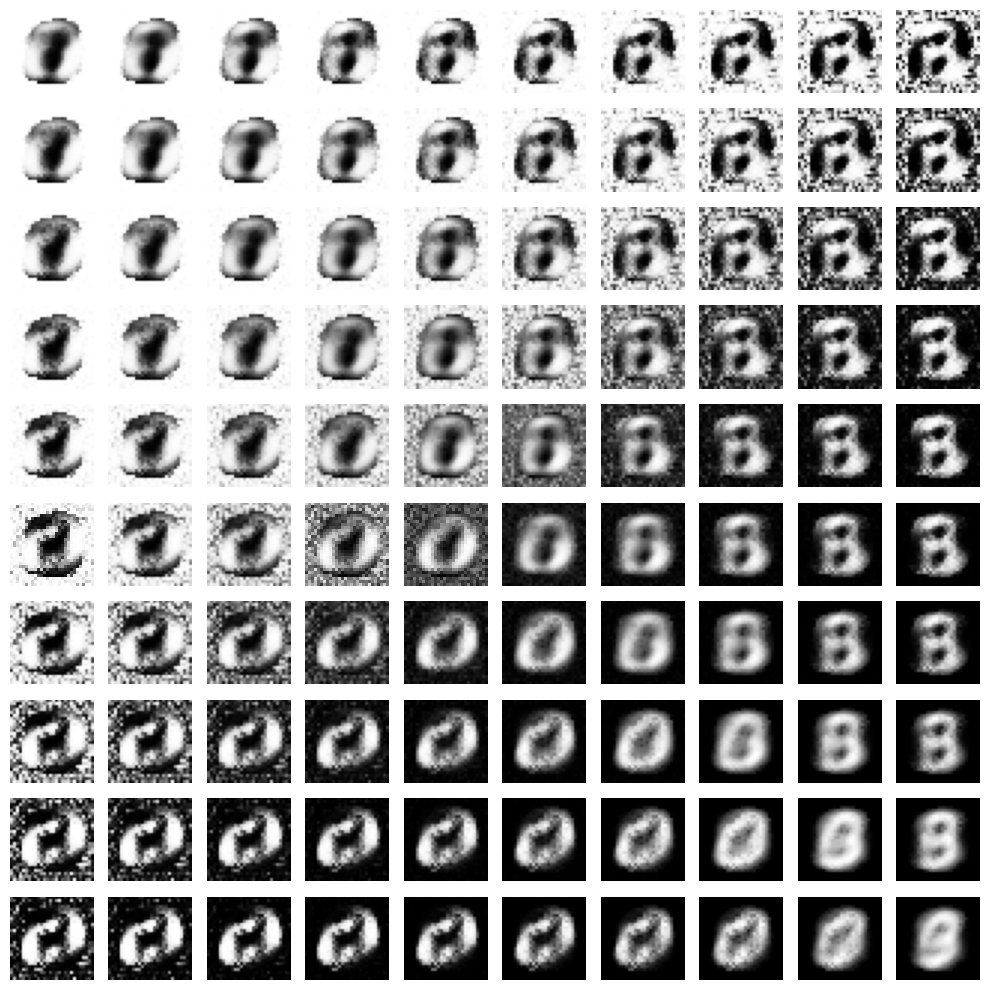

In [9]:
scatterplot(autoencoder, mnist_test_dataloader)
generate_examples(autoencoder, 10)

### 1.2 Autoencoder

Regular autoencoders have four steps: `encoder`, `bottleneck`, `decoder` and `head`. The encoder takes the input data and returns a transformation of the input. This would typically be a downsampled representation. The bottleneck takes the downsampled representation and produces the latent vector. The decoder decodes the latent back to the input modality. The head ensures the output is compatible with the input.

In [10]:
autoencoder = dtm.Autoencoder(hidden_dim=2)
autoencoder(torch.rand(1, 1, 28, 28))
autoencoder

Autoencoder(
  (encoder): ImageToImageEncoder(
    (blocks): ModuleList(
      (0): Template(
        (layer): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Template(
        (layer): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (output): Identity()
  )
  (bottleneck): Bottleneck(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=784, out_features=2, bias=True)
    (activation): Identity()
  )
  (decoder): VectorToImageDecoder(
    (input): Template(
      (layer): Linear(in_features=2, out_features=784, bias=True)
      (connector): Unflatten(dim=1, unflattened_size=torch.Size([16, 7, 7]))
    )
    (blocks): ModuleList(
      (0): Template(
    

In [11]:

trainer = pl.Trainer(max_epochs=5, accelerator="cuda")
trainer.fit(autoencoder, mnist_dataloader, mnist_test_dataloader)
trainer.test(dataloaders=mnist_test_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                 | Params
----------------------------------------------------
0 | encoder    | ImageToImageEncoder  | 1.2 K 
1 | bottleneck | Bottleneck           | 1.6 K 
2 | decoder    | VectorToImageDecoder | 30.1 K
3 | head       | ImageGeneratorHead   | 33    
4 | loss       | MSELoss              | 0     
----------------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.132     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_66\checkpoints\epoch=4-step=9375.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_66\checkpoints\epoch=4-step=9375.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04949188977479935    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04949188977479935}]

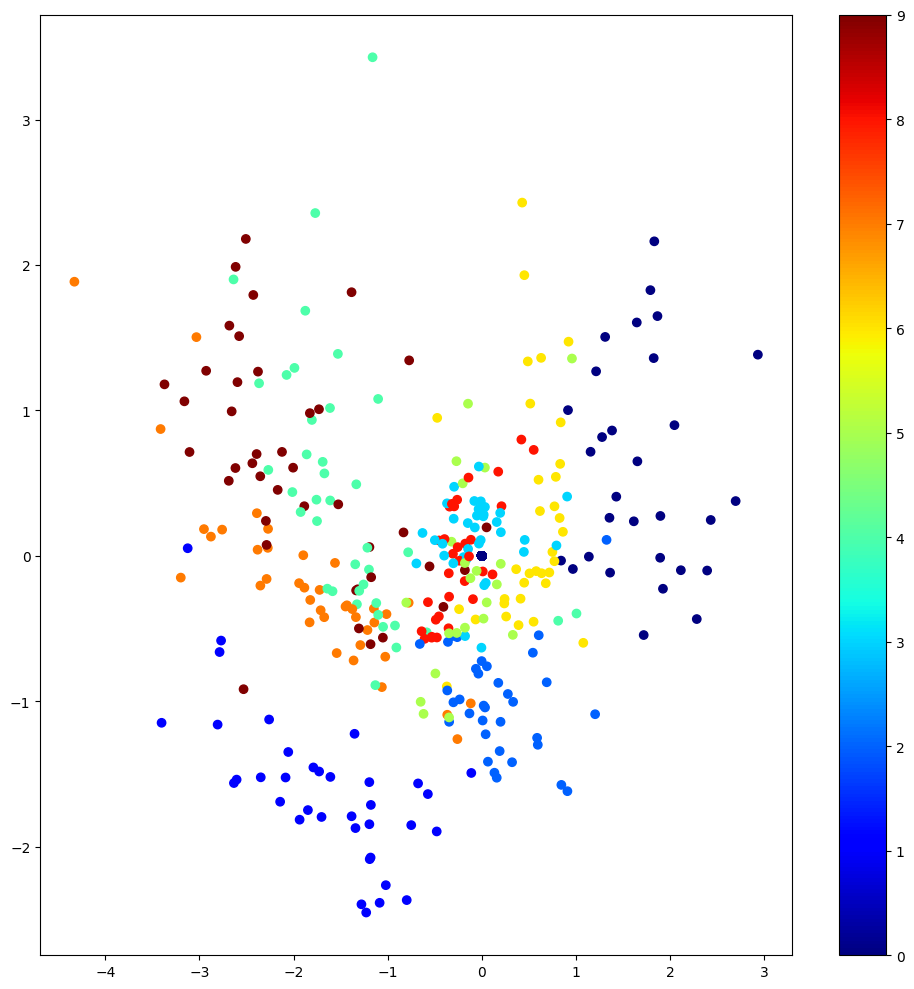

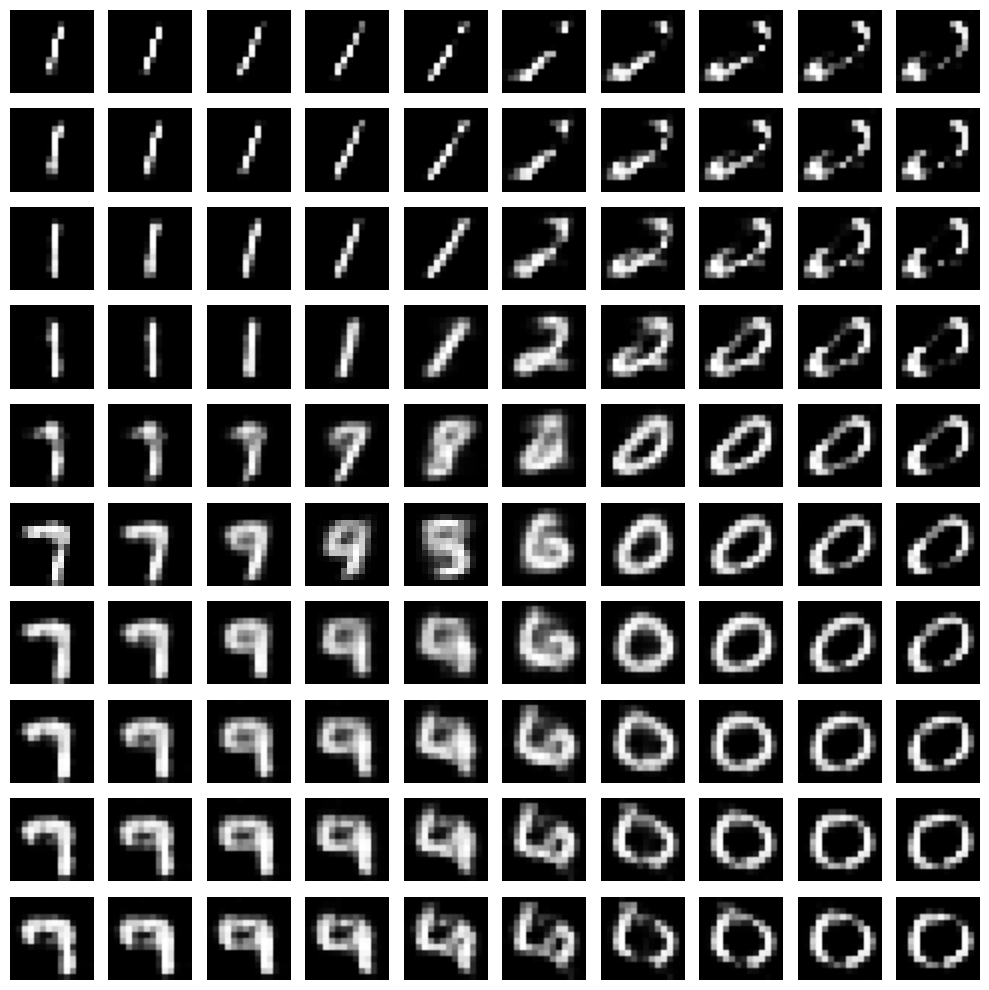

In [12]:
scatterplot(autoencoder, mnist_test_dataloader)
generate_examples(autoencoder, 10)

In [13]:
vae = dtm.VariationalAutoencoder.from_config(
    dtm.Config()
    .hidden_dim(2)
)
vae(torch.randn(1, 1, 28, 28))
vae

VariationalAutoencoder(
  (encoder): ImageToImageEncoder(
    (blocks): ModuleList(
      (0): Template(
        (layer): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Template(
        (layer): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (output): Identity()
  )
  (bottleneck): VariationalBottleneck(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (samplers): ModuleList(
      (0): NormalDistribtionSampler(
        (loc): Identity()
      )
      (1): NormalDistribtionSampler(
        (loc): Identity()
      )
    )
    (layer): Linear(in_features=784, out_features=4, bias=True)
    (activation): Identity()
  )
  (decoder): VectorToImageDecoder(
    (input): Template(
  

In [14]:


trainer = pl.Trainer(max_epochs=5, accelerator="cuda")
trainer.fit(vae, mnist_dataloader, mnist_test_dataloader)
trainer.test(dataloaders=mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params
-----------------------------------------------------
0 | encoder    | ImageToImageEncoder   | 1.2 K 
1 | bottleneck | VariationalBottleneck | 3.1 K 
2 | decoder    | VectorToImageDecoder  | 30.1 K
3 | head       | ImageGeneratorHead    | 33    
4 | loss       | MSELoss               | 0     
-----------------------------------------------------
34.5 K    Trainable params
0         Non-trainable params
34.5 K    Total params
0.138     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_67\checkpoints\epoch=4-step=9375.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_67\checkpoints\epoch=4-step=9375.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       kl_loss_epoch       │   0.0005660314345732331   │
│ reconstruction_loss_epoch │    0.06852670013904572    │
│         test_loss         │     49.88801193237305     │
└───────────────────────────┴───────────────────────────┘

[{'reconstruction_loss_epoch': 0.06852670013904572,
  'kl_loss_epoch': 0.0005660314345732331,
  'test_loss': 49.88801193237305}]

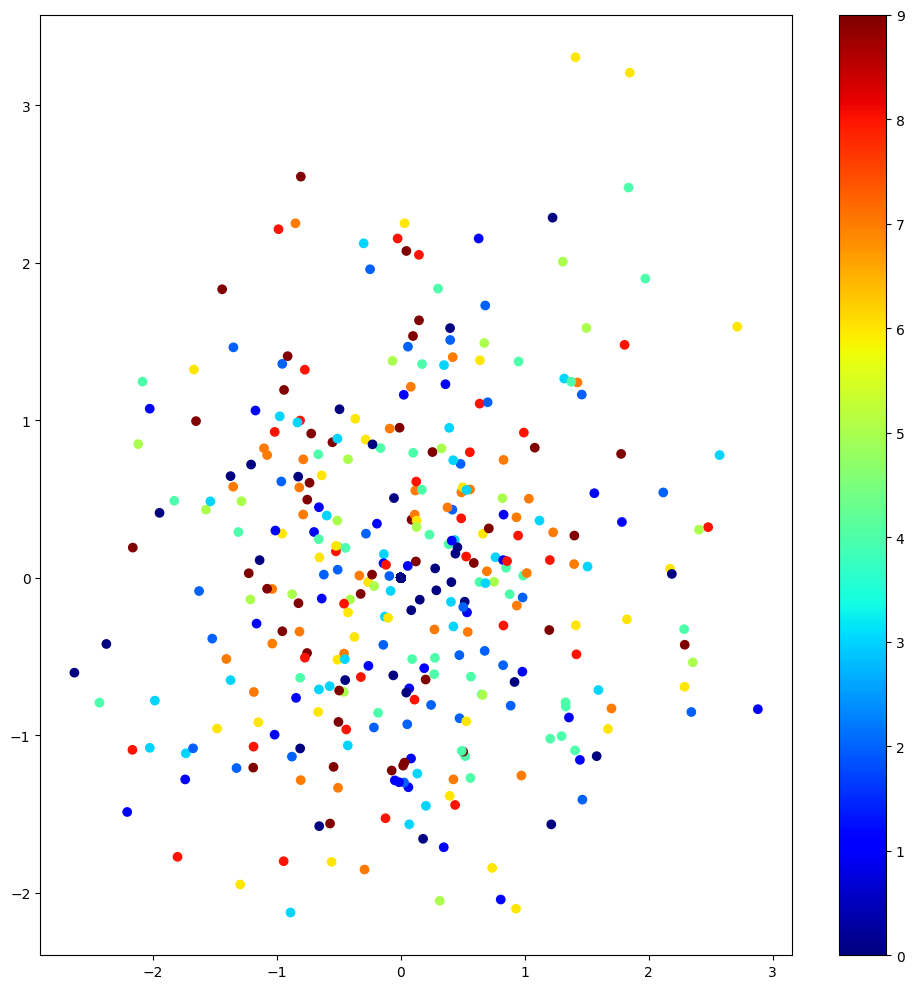

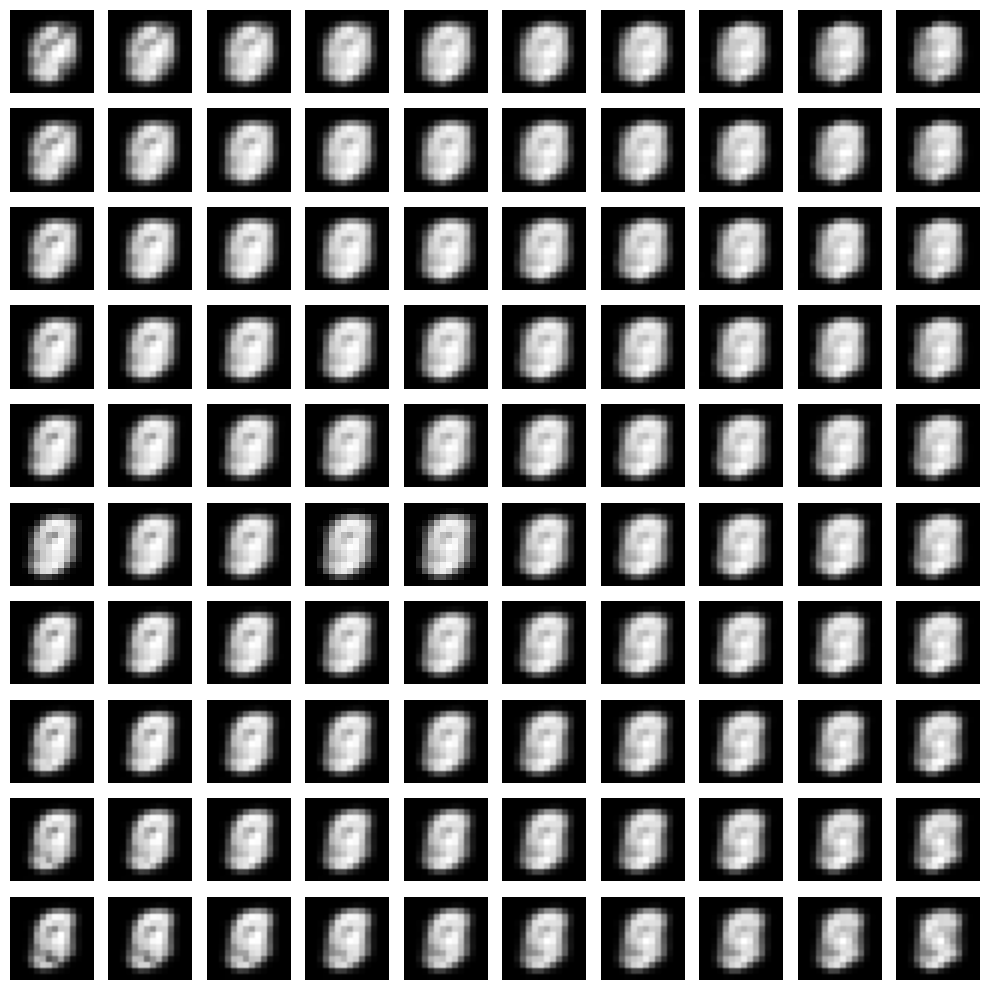

In [15]:
scatterplot(vae, mnist_test_dataloader)
generate_examples(vae, 10)

In [21]:
vae = dtm.BetaVAE.from_config(
    dtm.Config()
    .hidden_dim(2)
    .beta(0.1)
)
vae(torch.randn(1, 1, 28, 28))
vae

BetaVAE(
  (encoder): ImageToImageEncoder(
    (blocks): ModuleList(
      (0): Template(
        (layer): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Template(
        (layer): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (output): Identity()
  )
  (bottleneck): VariationalBottleneck(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (samplers): ModuleList(
      (0): NormalDistribtionSampler(
        (loc): Identity()
      )
      (1): NormalDistribtionSampler(
        (loc): Identity()
      )
    )
    (layer): Linear(in_features=784, out_features=4, bias=True)
    (activation): Identity()
  )
  (decoder): VectorToImageDecoder(
    (input): Template(
      (layer): Li

In [22]:
trainer = pl.Trainer(max_epochs=5, accelerator="cuda")
trainer.fit(vae, mnist_dataloader, mnist_test_dataloader)
trainer.test(dataloaders=mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params
-----------------------------------------------------
0 | encoder    | ImageToImageEncoder   | 1.2 K 
1 | bottleneck | VariationalBottleneck | 3.1 K 
2 | decoder    | VectorToImageDecoder  | 30.1 K
3 | head       | ImageGeneratorHead    | 33    
4 | loss       | MSELoss               | 0     
-----------------------------------------------------
34.5 K    Trainable params
0         Non-trainable params
34.5 K    Total params
0.138     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_70\checkpoints\epoch=11-step=22500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_70\checkpoints\epoch=11-step=22500.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       kl_loss_epoch       │     7.699295997619629     │
│ reconstruction_loss_epoch │    0.06580360978841782    │
│         test_loss         │     49.44485855102539     │
└───────────────────────────┴───────────────────────────┘

[{'reconstruction_loss_epoch': 0.06580360978841782,
  'kl_loss_epoch': 7.699295997619629,
  'test_loss': 49.44485855102539}]

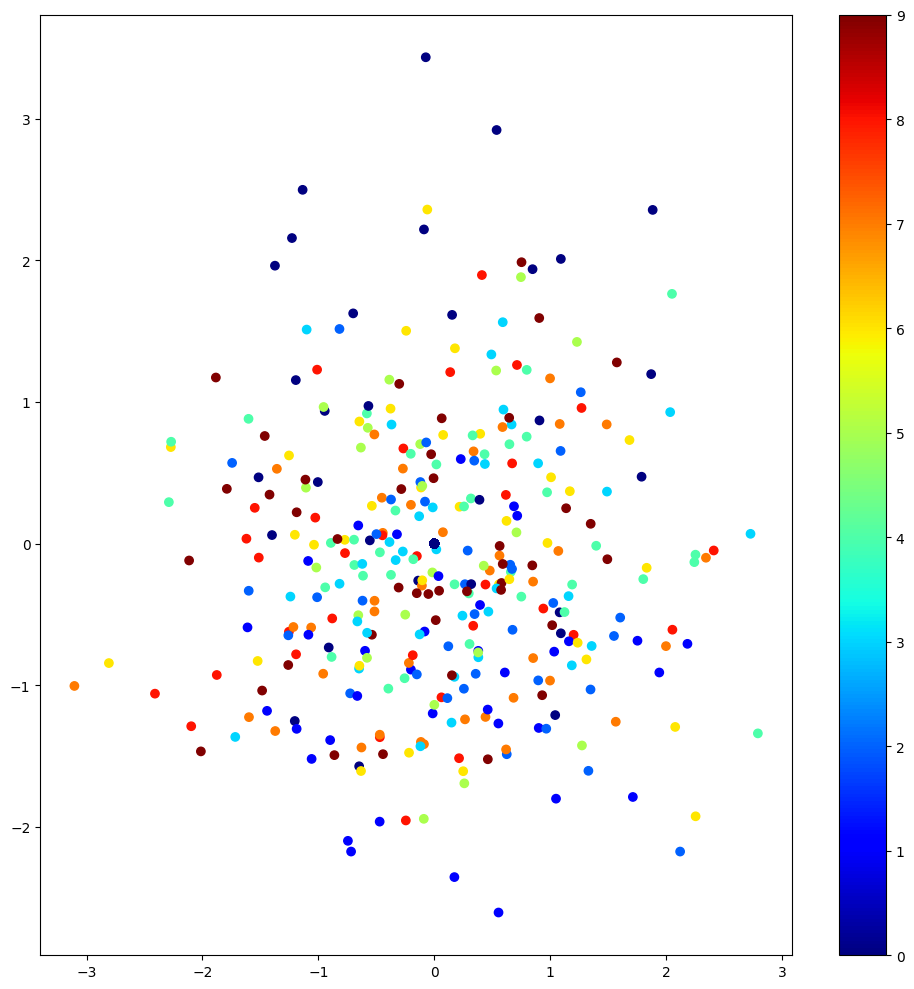

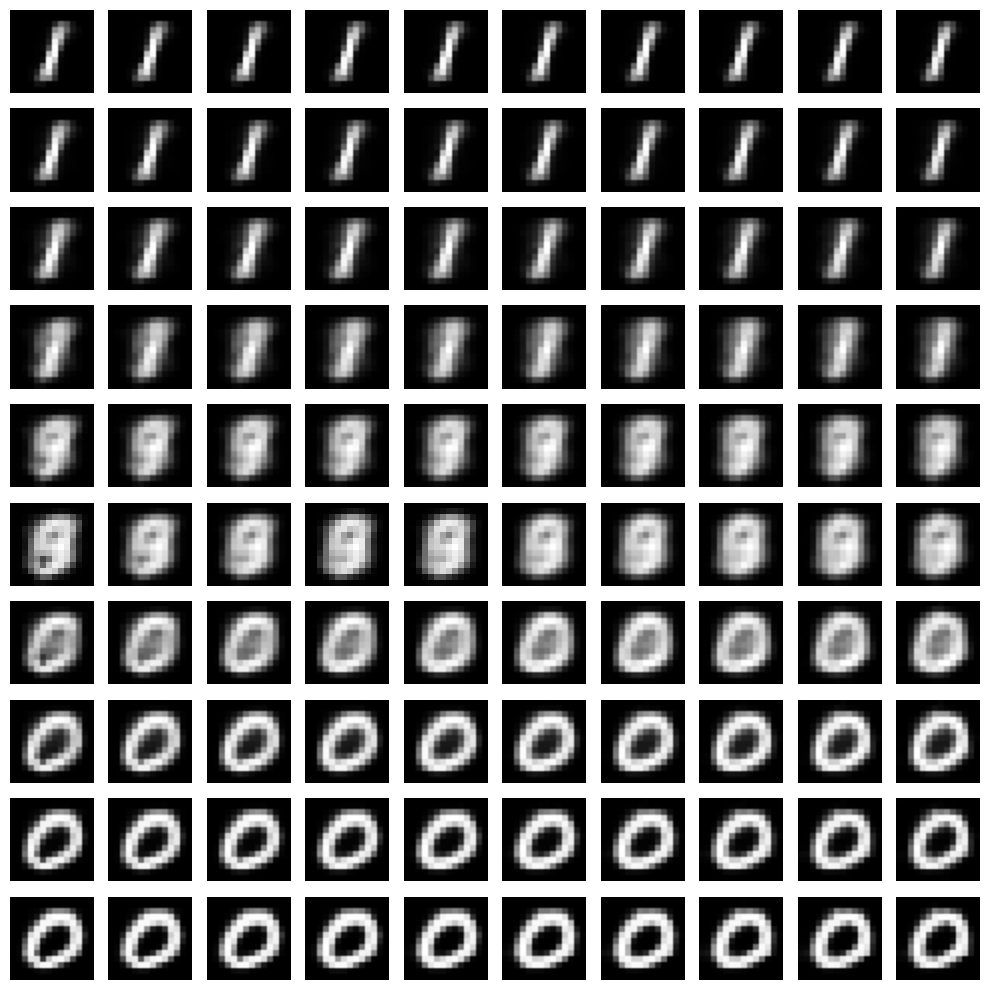

In [23]:
scatterplot(vae, mnist_test_dataloader)
generate_examples(vae, 10)